# Import requirements

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 14.2 MB/s 
     |████████████████████████████████| 7.6 MB 84.9 MB/s 
     |████████████████████████████████| 182 kB 103.6 MB/s 


In [ ]:
import os
import pdb
import argparse
from dataclasses import dataclass, field
from typing import Optional
from collections import defaultdict

import torch
from torch.nn.utils.rnn import pad_sequence

import numpy as np
from tqdm import tqdm, trange

from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    AutoConfig,
    AdamW
)

# 1. Preprocess

### **여기부터 코드 추가 **

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/goorm/Proj1/data # 파일폴더 경로 설정

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: '/content/drive/MyDrive/goorm/Proj1/data # 파일폴더 경로 설정'
/content/drive/MyDrive/goorm/Proj1/data


In [ ]:
ls  #폴더 내 파일보기

pytorch_model.bin              sentiment.train.0_cleaning1.txt
sentiment.dev.0                sentiment.train.0_cleaning.txt
sentiment.dev.0_cleaning1.txt  sentiment.train.1
sentiment.dev.0_cleaning.txt   sentiment.train.1_cleaning1.txt
sentiment.dev.1                sentiment.train.1_cleaning.txt
sentiment.dev.1_cleaning1.txt  submission.csv
sentiment.dev.1_cleaning.txt   test_no_label_cleaning.csv
sentiment.train.0              test_no_label.csv


In [ ]:
file_list = ['sentiment.train.0','sentiment.train.1','sentiment.dev.0','sentiment.dev.1']

#NLP AUGMENTATION

In [ ]:
# 데이터 수 확인
train_neg_file = pd.read_csv('sentiment.train.0',  header=None, sep = "\t", engine='python', encoding = "cp949")
train_pos_file = pd.read_csv('sentiment.train.1',  header=None, sep = "\t", engine='python', encoding = "cp949")
print(train_neg_file.count())
print(train_pos_file.count())

0    177218
dtype: int64
0    266041
dtype: int64


In [ ]:
# train data의 부정(0) : 긍정(1) 비율은 40:60 으로 데이터 불균형 --> NLPAUG 실시

df = pd.DataFrame({'neg' : ['177218'], 'pos' : ['266041']})
df['total'] = int(df['neg']) + int(df['pos'])
df['neg_percent'] = round(int(df['neg']) / int(df['total']) * 100, 1)
df['pos_percent'] = round(100 - df['neg_percent'], 1)
df

,neg,pos,total,neg_percent,pos_percent
0,177218,266041,443259,40.0,60.0


In [ ]:
# NLPAUG 참고사이트 https://github.com/makcedward/nlpaug/blob/master/example/textual_augmenter.ipynb

In [ ]:
!pip install torch>=1.6.0 transformers>=4.11.3 sentencepiece
!pip install numpy requests nlpaug

# 위 버전이 모델분석에 방해된다면, AUG와 모델분석은 다른 파일에서 각각 진행

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 410 kB 14.2 MB/s 


In [ ]:
import os
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

In [ ]:
aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="insert")  
    # model_path='distilbert-base-uncased', 'roberta-base' 가능
    # action="substitute"가능

In [ ]:
#AUG 샘플예시
text = 'The quick brown fox jumps over the lazy dog .'
print(text)

augmented_text = aug.augment(text, n=2) #1문장 당 n개 설정가능
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

The quick brown fox jumps over the lazy dog .
Original:
The quick brown fox jumps over the lazy dog .
Augmented Text:
['the old quick brown fox instinctively jumps over for the lazy dog.', 'the quick young brown fox dog jumps over the remaining lazy dog.']


In [ ]:
for sentence in train_neg_file[0]:
    augmented_text = aug.augment(sentence, n=3) #1문장 당 n개 설정가능
                                                                #neg data(177218개)는 n=3으로 531654개, 
                                                                #pos data(266041개)는 n=2으로 532082개
    train_neg_file = train_neg_file.append((augmented_text),ignore_index=True)

train_neg_file = pd.DataFrame(train_neg_file)
train_neg_file.to_csv("./train_neg_aug.txt", index=False, header = None)

In [ ]:
train_neg_file.count()

In [ ]:
cnt = 0
for sentence in train_pos_file[0]:
    augmented_text = aug.augment(sentence, n=2) #1문장 당 n개 설정가능
                                                                #pos data(266041개)는 n=2으로 532082개
    train_pos_file = train_pos_file.append((augmented_text),ignore_index=True)
    cnt += 1
    print(cnt)

train_pos_file = pd.DataFrame(train_pos_file)
train_pos_file.to_csv("./train_neg_aug.txt", index=False, header = None)

In [ ]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')


def preprocessing(review, remove_stopwords=False):
    # 불용어 제거는 옵션으로 선택 가능하며, 본 플젝에서는 불용어 제거 안 함 (False 고정)
    
    # 1. HTML 태그 제거
    #review_text=BeautifulSoup(review, "html5lib").get_text()
    
    # 2. _num_ 공백으로 대체 및 haven't와 같은 단어는 not으로 대체
    review = review.replace('_num_',' ')
    review = review.replace("n't",'not')

    # 3. 영어가 아닌 특수문자를 공백(" ")으로 바꾸기
    review_text=re.sub("[^a-zA-Z]", " ", review)
    
    # 4. 대문자를 소문자로 바꾸고 공백 단위로 텍스트를 나눠서 리스트로 만든다.
    words=review_text.lower().split()

    if remove_stopwords:
        # 5. 불용어 제거
        
        # 영어 불용어 불러오기
        stops=set(stopwords.words("english"))
        # 불용어가 아닌 단어로 이뤄진 새로운 리스트 생성
        words=[w for w in words if not w in stops]
        # 5. 단어 리스트를 공백을 넣어서 하나의 글로 합친다.
        clean_review=' '.join(words)
    
    # 불용어를 제거하지 않을 때
    else:
        clean_review=' '.join(words)

    return clean_review

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 80

리뷰의 최대 길이 : 108
리뷰의 평균 길이 : 44.50581769346229


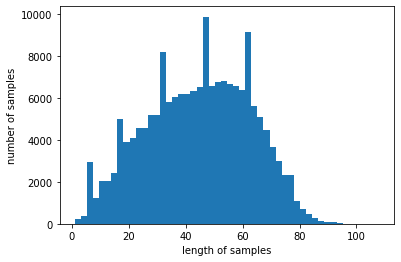

전체 샘플 중 길이가 80 이하인 샘플의 비율: 98.98994458802153
리뷰의 최대 길이 : 104
리뷰의 평균 길이 : 40.744505546137624


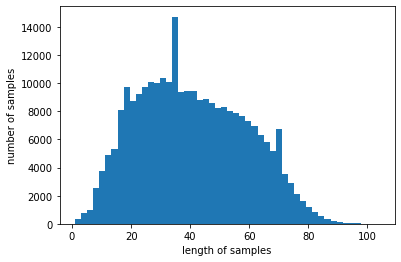

전체 샘플 중 길이가 80 이하인 샘플의 비율: 98.93888535977537
리뷰의 최대 길이 : 102
리뷰의 평균 길이 : 43.8025


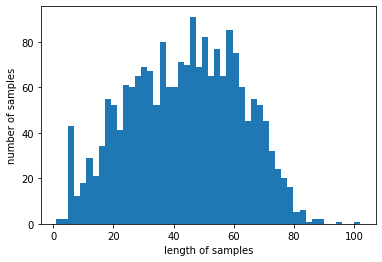

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.3
리뷰의 최대 길이 : 92
리뷰의 평균 길이 : 40.4575


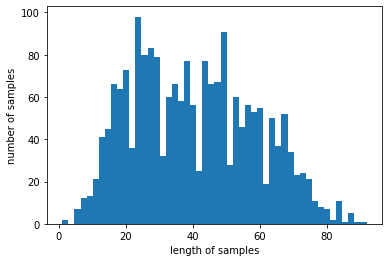

전체 샘플 중 길이가 80 이하인 샘플의 비율: 98.8


In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

for file_name in file_list :
    file = pd.read_csv(file_name,  header=None, sep = "\t", engine='python', encoding = "cp949")

    if "train" in file_name :
        clean_train_reviews=[]

        for review in file[0]:
            clean_review = preprocessing(review,remove_stopwords=False)
            clean_train_reviews.append(clean_review)
        
        clean_train_df = pd.DataFrame(clean_train_reviews)
        clean_train_df.to_csv("./"+file_name+"_cleaning.txt", index=False, header = None)

        print('리뷰의 최대 길이 :',max(len(review) for review in file[0]))
        print('리뷰의 평균 길이 :',sum(map(len, file[0]))/len(file[0]))
        plt.hist([len(review) for review in file[0]], bins=50)
        plt.xlabel('length of samples')
        plt.ylabel('number of samples')
        plt.show()
        below_threshold_len(max_len, file[0])

    else :
        clean_dev_reviews=[]

        for review in file[0]:
            clean_review = preprocessing(review,remove_stopwords=False)
            clean_dev_reviews.append(clean_review)
        
        clean_dev_df=pd.DataFrame(clean_dev_reviews)
        clean_dev_df.to_csv("./"+file_name+"_cleaning.txt", index=False, header = None)

        print('리뷰의 최대 길이 :',max(len(review) for review in file[0]))
        print('리뷰의 평균 길이 :',sum(map(len, file[0]))/len(file[0]))
        plt.hist([len(review) for review in file[0]], bins=50)
        plt.xlabel('length of samples')
        plt.ylabel('number of samples')
        plt.show()
        below_threshold_len(max_len, file[0])
    

In [ ]:
def make_id_file(task, tokenizer):
    def make_data_strings(file_name):
        data_strings = []
        with open(os.path.join(file_name), 'r', encoding='utf-8') as f:
            id_file_data = [tokenizer.encode(line.lower()) for line in f.readlines()]
        for item in id_file_data:
            data_strings.append(' '.join([str(k) for k in item]))
        return data_strings
    
    print('it will take some times...')
    train_pos = make_data_strings('sentiment.train.1_cleaning.txt') #클리닝 완료한 파일명으로 설정
    train_neg = make_data_strings('sentiment.train.0_cleaning.txt') #클리닝 완료한 파일명으로 설정
    dev_pos = make_data_strings('sentiment.dev.1_cleaning.txt') #클리닝 완료한 파일명으로 설정
    dev_neg = make_data_strings('sentiment.dev.0_cleaning.txt') #클리닝 완료한 파일명으로 설정

    print('make id file finished!')
    return train_pos, train_neg, dev_pos, dev_neg

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_pos, train_neg, dev_pos, dev_neg = make_id_file('yelp', tokenizer)

it will take some times...
make id file finished!


In [ ]:
train_pos[:10]

['101 6581 2833 102',
 '101 21688 8013 2326 102',
 '101 2027 2036 2031 3679 19247 1998 3256 6949 2029 2003 2428 2204 102',
 '101 2009 1055 1037 2204 15174 2098 7570 22974 2063 102',
 '101 1996 3095 2003 5379 102',
 '101 2204 3347 2833 102',
 '101 2204 2326 102',
 '101 11350 1997 2154 2003 25628 1998 7167 1997 19247 102',
 '101 2307 2173 2005 6265 2030 3347 27962 1998 5404 102',
 '101 1996 2047 2846 3504 6429 102']

In [ ]:
class SentimentDataset(object):
    def __init__(self, tokenizer, pos, neg):
        self.tokenizer = tokenizer
        self.data = []
        self.label = []

        for pos_sent in pos:
            self.data += [self._cast_to_int(pos_sent.strip().split())]
            self.label += [[1]]
        for neg_sent in neg:
            self.data += [self._cast_to_int(neg_sent.strip().split())]
            self.label += [[0]]

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample), np.array(self.label[index])

In [ ]:
train_dataset = SentimentDataset(tokenizer, train_pos, train_neg)
dev_dataset = SentimentDataset(tokenizer, dev_pos, dev_neg)

In [ ]:
for i, item in enumerate(train_dataset):
    print(item)
    if i == 10:
        break

(array([ 101, 6581, 2833,  102]), array([1]))
(array([  101, 21688,  8013,  2326,   102]), array([1]))
(array([  101,  2027,  2036,  2031,  3679, 19247,  1998,  3256,  6949,
        2029,  2003,  2428,  2204,   102]), array([1]))
(array([  101,  2009,  1055,  1037,  2204, 15174,  2098,  7570, 22974,
        2063,   102]), array([1]))
(array([ 101, 1996, 3095, 2003, 5379,  102]), array([1]))
(array([ 101, 2204, 3347, 2833,  102]), array([1]))
(array([ 101, 2204, 2326,  102]), array([1]))
(array([  101, 11350,  1997,  2154,  2003, 25628,  1998,  7167,  1997,
       19247,   102]), array([1]))
(array([  101,  2307,  2173,  2005,  6265,  2030,  3347, 27962,  1998,
        5404,   102]), array([1]))
(array([ 101, 1996, 2047, 2846, 3504, 6429,  102]), array([1]))
(array([ 101, 2023, 2173, 2001, 2200, 2204,  102]), array([1]))


In [ ]:
def collate_fn_style(samples):
    input_ids, labels = zip(*samples)
    max_len = max(len(input_id) for input_id in input_ids)

    sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1]

    input_ids = pad_sequence([torch.tensor(input_ids[index]) for index in sorted_indices],
                             batch_first=True)

    attention_mask = torch.tensor(
        [[1] * len(input_ids[index]) + [0] * (max_len - len(input_ids[index])) for index in
         sorted_indices])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])
    labels = torch.tensor(np.stack(labels, axis=0)[sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids, labels

In [ ]:
train_batch_size=256
eval_batch_size=512

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=train_batch_size,
                                           shuffle=True, collate_fn=collate_fn_style,
                                           pin_memory=True, num_workers=2)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=eval_batch_size,
                                         shuffle=False, collate_fn=collate_fn_style,
                                         num_workers=2)

In [ ]:
# random seed
random_seed=42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model.to(device)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
model.train()
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def compute_acc(predictions, target_labels):
    return (np.array(predictions) == np.array(target_labels)).mean()

In [ ]:
#train_epoch = 3
train_epoch = 1
lowest_valid_loss = 9999.
for epoch in range(train_epoch):
    with tqdm(train_loader, unit="batch") as tepoch:
        for iteration, (input_ids, attention_mask, token_type_ids, position_ids, labels) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            position_ids = position_ids.to(device)
            labels = labels.to(device, dtype=torch.long)

            optimizer.zero_grad()

            output = model(input_ids=input_ids,
                           attention_mask=attention_mask,
                           token_type_ids=token_type_ids,
                           position_ids=position_ids,
                           labels=labels)

            loss = output.loss
            loss.backward()

            optimizer.step()

            tepoch.set_postfix(loss=loss.item())
            if iteration != 0 and iteration % int(len(train_loader) / 5) == 0:
                # Evaluate the model five times per epoch
                with torch.no_grad():
                    model.eval()
                    valid_losses = []
                    predictions = []
                    target_labels = []
                    for input_ids, attention_mask, token_type_ids, position_ids, labels in tqdm(dev_loader,
                                                                                                desc='Eval',
                                                                                                position=1,
                                                                                                leave=None):
                        input_ids = input_ids.to(device)
                        attention_mask = attention_mask.to(device)
                        token_type_ids = token_type_ids.to(device)
                        position_ids = position_ids.to(device)
                        labels = labels.to(device, dtype=torch.long)

                        output = model(input_ids=input_ids,
                                       attention_mask=attention_mask,
                                       token_type_ids=token_type_ids,
                                       position_ids=position_ids,
                                       labels=labels)

                        logits = output.logits
                        loss = output.loss
                        valid_losses.append(loss.item())

                        batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
                        batch_labels = [int(example) for example in labels]

                        predictions += batch_predictions
                        target_labels += batch_labels

                acc = compute_acc(predictions, target_labels)
                valid_loss = sum(valid_losses) / len(valid_losses)
                if lowest_valid_loss > valid_loss:
                    print('Acc for model which have lower valid loss: ', acc)
                    torch.save(model.state_dict(), "./pytorch_model.bin")
                    # lowest_valid_loss = valid_loss
                print("#############################")
                print(lowest_valid_loss - valid_loss)

Eval: 100%|██████████| 8/8 [00:01<00:00,  7.00it/s]
                                                   

Acc for model which have lower valid loss:  0.97325


Epoch 0:  20%|██        | 347/1732 [01:18<48:01,  2.08s/batch, loss=0.0606]

#############################
9998.923809177708


Eval: 100%|██████████| 8/8 [00:01<00:00,  7.02it/s]
                                                   

Acc for model which have lower valid loss:  0.97275


Epoch 0:  40%|████      | 693/1732 [02:28<15:40,  1.10batch/s, loss=0.0498]

#############################
9998.925091863144


Eval: 100%|██████████| 8/8 [00:01<00:00,  6.99it/s]
                                                   

Acc for model which have lower valid loss:  0.97475


Epoch 0:  60%|█████▉    | 1039/1732 [03:38<10:23,  1.11batch/s, loss=0.0659]

#############################
9998.927581515163


Eval: 100%|██████████| 8/8 [00:01<00:00,  7.00it/s]
                                                   

Acc for model which have lower valid loss:  0.97625


Epoch 0:  80%|███████▉  | 1385/1732 [04:49<05:12,  1.11batch/s, loss=0.0402]

#############################
9998.933617509902


Eval: 100%|██████████| 8/8 [00:01<00:00,  7.00it/s]
                                                   

Acc for model which have lower valid loss:  0.979


Epoch 0: 100%|██████████| 1732/1732 [06:00<00:00,  4.81batch/s, loss=0.0144]

#############################
9998.940171243157


In [ ]:
test_df = pd.read_csv('test_no_label.csv')

In [ ]:
test_df['Id']

0      it 's a whole new experience and new flavors e...
1                so disappointing from an old favorite .
2          it is the most authentic thai in the valley .
3                do not sign a lease with these people .
4      i was nervous and she made me feel so comforta...
                             ...                        
995                         the food here is delicious .
996                           we 'll certainly be back !
997                the building itself looks abandoned .
998             if i could give zero stars i def would .
999    the beer is n't bad , but the food was less th...
Name: Id, Length: 1000, dtype: object

In [ ]:
clean_test_reviews=[]

for review in test_df['Id']:
    clean_review = preprocessing(review,remove_stopwords=False)
    clean_test_reviews.append(clean_review)

clean_test_df=pd.DataFrame(clean_test_reviews)
clean_test_df.to_csv("./test_no_label_cleaning.csv", index=False, header = None)

In [ ]:
test_dataset = clean_test_df[0]

In [ ]:
def make_id_file_test(tokenizer, test_dataset):
    data_strings = []
    id_file_data = [tokenizer.encode(sent.lower()) for sent in test_dataset]
    for item in id_file_data:
        data_strings.append(' '.join([str(k) for k in item]))
    return data_strings

In [ ]:
test = make_id_file_test(tokenizer, test_dataset)

In [ ]:
test[:10]

['101 2009 1055 1037 2878 2047 3325 1998 2047 26389 2169 2051 2017 2175 102',
 '101 2061 15640 2013 2019 2214 5440 102',
 '101 2009 2003 1996 2087 14469 7273 1999 1996 3028 102',
 '101 2079 2025 3696 1037 10084 2007 2122 2111 102',
 '101 1045 2001 6091 1998 2016 2081 2033 2514 2061 6625 1998 6160 102',
 '101 1996 2069 2518 2057 2363 2008 2001 2980 2001 1996 4157 102',
 '101 2053 2025 1996 3924 2012 2004 2226 1996 3924 1999 3502 2152 102',
 '101 2027 3288 2009 2041 2392 2005 2017 1998 2024 2200 14044 102',
 '101 4606 1996 12043 2106 2025 2130 2113 2129 2000 2147 1996 3274 102',
 '101 2027 2031 2019 6581 4989 1997 25025 2015 2000 5454 2013 102']

In [ ]:
class SentimentTestDataset(object):
    def __init__(self, tokenizer, test):
        self.tokenizer = tokenizer
        self.data = []

        for sent in test:
            self.data += [self._cast_to_int(sent.strip().split())]

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample)

In [ ]:
test_dataset = SentimentTestDataset(tokenizer, test)

In [ ]:
def collate_fn_style_test(samples):
    input_ids = samples
    max_len = max(len(input_id) for input_id in input_ids)

    #sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1] #bug
    sorted_indices = [i for i in range(len(input_ids))]
    input_ids = pad_sequence([torch.tensor(input_ids[index]) for index in sorted_indices],batch_first=True)
    attention_mask = torch.tensor(
        [[1] * len(input_ids[index]) + [0] * (max_len - len(input_ids[index])) for index in
         sorted_indices])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids

In [ ]:
test_batch_size = 32
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size,
                                          shuffle=False, collate_fn=collate_fn_style_test,
                                          num_workers=2)

In [ ]:
with torch.no_grad():
    model.eval()
    predictions = []
    for input_ids, attention_mask, token_type_ids, position_ids in tqdm(test_loader,
                                                                        desc='Test',
                                                                        position=1,
                                                                        leave=None):

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        position_ids = position_ids.to(device)

        output = model(input_ids=input_ids,
                       attention_mask=attention_mask,
                       token_type_ids=token_type_ids,
                       position_ids=position_ids)

        logits = output.logits
        print(logits)
        batch_predictions = [0 if example[0] > example[1] else 1 for example in logits] ###????
        predictions += batch_predictions


Test:  22%|██▏       | 7/32 [00:00<00:00, 32.91it/s]

tensor([[-4.0688,  4.2627],
        [ 3.1845, -2.8879],
        [-3.9831,  4.2295],
        [ 4.0804, -3.4644],
        [-3.2311,  3.1208],
        [ 3.3274, -2.8744],
        [ 3.3100, -2.6219],
        [-3.2805,  3.1083],
        [ 4.0567, -3.4781],
        [-4.3351,  4.5442],
        [-3.9109,  4.0590],
        [ 4.3265, -4.3002],
        [ 3.1092, -2.3698],
        [-3.6649,  3.6484],
        [-4.1248,  4.3277],
        [ 4.2801, -4.0959],
        [ 0.7616,  0.1134],
        [-3.0538,  2.9437],
        [ 3.4494, -2.7393],
        [ 4.0347, -3.4175],
        [ 3.4354, -2.6711],
        [-3.6357,  3.5638],
        [ 1.9409, -1.2114],
        [-3.8116,  3.9212],
        [ 2.7933, -2.1931],
        [ 3.5066, -2.8131],
        [-2.4600,  2.4069],
        [-2.1591,  2.2318],
        [ 1.6486, -0.8558],
        [ 4.1470, -3.9960],
        [ 4.2512, -3.9168],
        [ 3.3925, -2.8446]], device='cuda:0')
tensor([[ 3.3981, -2.9563],
        [ 4.4250, -4.1206],
        [ 4.2296, -3.7192],
  


Test:  59%|█████▉    | 19/32 [00:00<00:00, 47.23it/s]

tensor([[ 4.4197, -4.0856],
        [-3.2629,  3.3669],
        [-4.1680,  4.3703],
        [-1.1099,  1.5560],
        [ 1.8344, -1.1356],
        [ 2.7683, -2.0233],
        [-3.5074,  3.5044],
        [ 4.4263, -4.0134],
        [ 3.4607, -2.7442],
        [-1.4131,  1.7779],
        [-4.0942,  4.1431],
        [ 2.2393, -1.5595],
        [ 3.8838, -3.4070],
        [-4.4062,  4.6045],
        [-4.3603,  4.5496],
        [-4.0863,  4.3394],
        [ 3.6885, -2.9713],
        [ 0.4218,  0.4352],
        [ 4.4214, -4.3772],
        [ 3.9827, -3.4781],
        [ 4.4237, -4.3197],
        [ 3.5200, -2.9000],
        [ 3.7660, -3.3941],
        [-0.0137,  0.7660],
        [-4.2083,  4.3932],
        [-4.2683,  4.4106],
        [-4.3560,  4.5266],
        [ 4.4881, -4.3442],
        [-3.8409,  3.8649],
        [-4.0413,  4.2808],
        [-3.5689,  3.5936],
        [-4.2098,  4.3148]], device='cuda:0')
tensor([[ 1.8446, -1.2235],
        [-3.6109,  3.5228],
        [ 2.1620, -1.5072],
  


Test:  97%|█████████▋| 31/32 [00:00<00:00, 52.28it/s]
                                                     

tensor([[-4.1943,  4.3810],
        [-1.0309,  1.4980],
        [ 0.1130,  0.6483],
        [-3.9622,  4.0436],
        [-0.8057,  1.4175],
        [ 3.9763, -3.5553],
        [-1.3545,  1.7868],
        [ 2.7798, -2.1175],
        [-2.1137,  2.2054],
        [ 4.4656, -4.3775],
        [ 2.7350, -2.0767],
        [-3.8865,  4.0730],
        [ 3.1885, -2.5189],
        [-4.0893,  4.2180],
        [-2.1840,  2.2587],
        [-3.1558,  2.9184],
        [-2.7233,  2.5657],
        [ 4.3090, -3.7810],
        [ 4.0744, -3.8944],
        [ 4.1596, -3.6095],
        [-3.8909,  4.0402],
        [-4.2866,  4.4484],
        [-3.7896,  3.8957],
        [ 3.5160, -2.9452],
        [-0.6014,  1.1361],
        [ 2.5731, -1.8894],
        [-4.2545,  4.5225],
        [ 3.8998, -3.8534],
        [-4.3362,  4.4900],
        [ 4.0232, -3.4744],
        [ 1.8533, -1.1672],
        [-2.3416,  2.4221]], device='cuda:0')
tensor([[ 4.0773, -3.6257],
        [ 3.9682, -3.3162],
        [-0.2011,  0.8127],
  

In [ ]:
test_df['Category'] = predictions

In [ ]:
test_df.to_csv('submission.csv', index=False)